In [21]:
import numpy as np
import xsimlab as xs
import xarray as xr
import matplotlib.pyplot as plt
import fastscape

from fastscape.processes import SurfaceTopography
from fastscape.processes import BlockUplift
from fastscape.processes import HorizontalAdvection
from fastscape.processes import Flexure
from fastscape.processes import Sea

from orographic_precipitation.fastscape_ext import OrographicPrecipitation
from orographic_precipitation.fastscape_ext import OrographicDrainageDischarge

%matplotlib inline

In [22]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.5.0
fastscape version:  0.1.0


In [ ]:
from fastscape.models import sediment_model        
from fastscape.processes import (                   
    SurfaceTopography,
    BlockUplift, HorizontalAdvection,
    Flexure,                       
    StreamPowerChannel,
    MultipleFlowRouter,
    DifferentialLinearDiffusion,     #
    DifferentialStreamPowerChannel
)
from orographic_precipitation.fastscape_ext import OrographicPrecipitation
#from fastscape_orographic_precip import OrographicPrecipitation 

In [ ]:
HIM_model = (
    sediment_model
    .drop_processes({                       
        "sea", "channel", "diffusion", "climate", "isostasy" ,"init_topography"
    })
    .update_processes({                     
        "topography": SurfaceTopography,
        "uplift"    : BlockUplift,
        "advection" : HorizontalAdvection,
        "flow"      : MultipleFlowRouter,
        "spl"       : DifferentialStreamPowerChannel,
        "diffusion" : DifferentialLinearDiffusion,
        "climate"   : OrographicPrecipitation,
        "isostasy"  : Flexure                 
    })
)

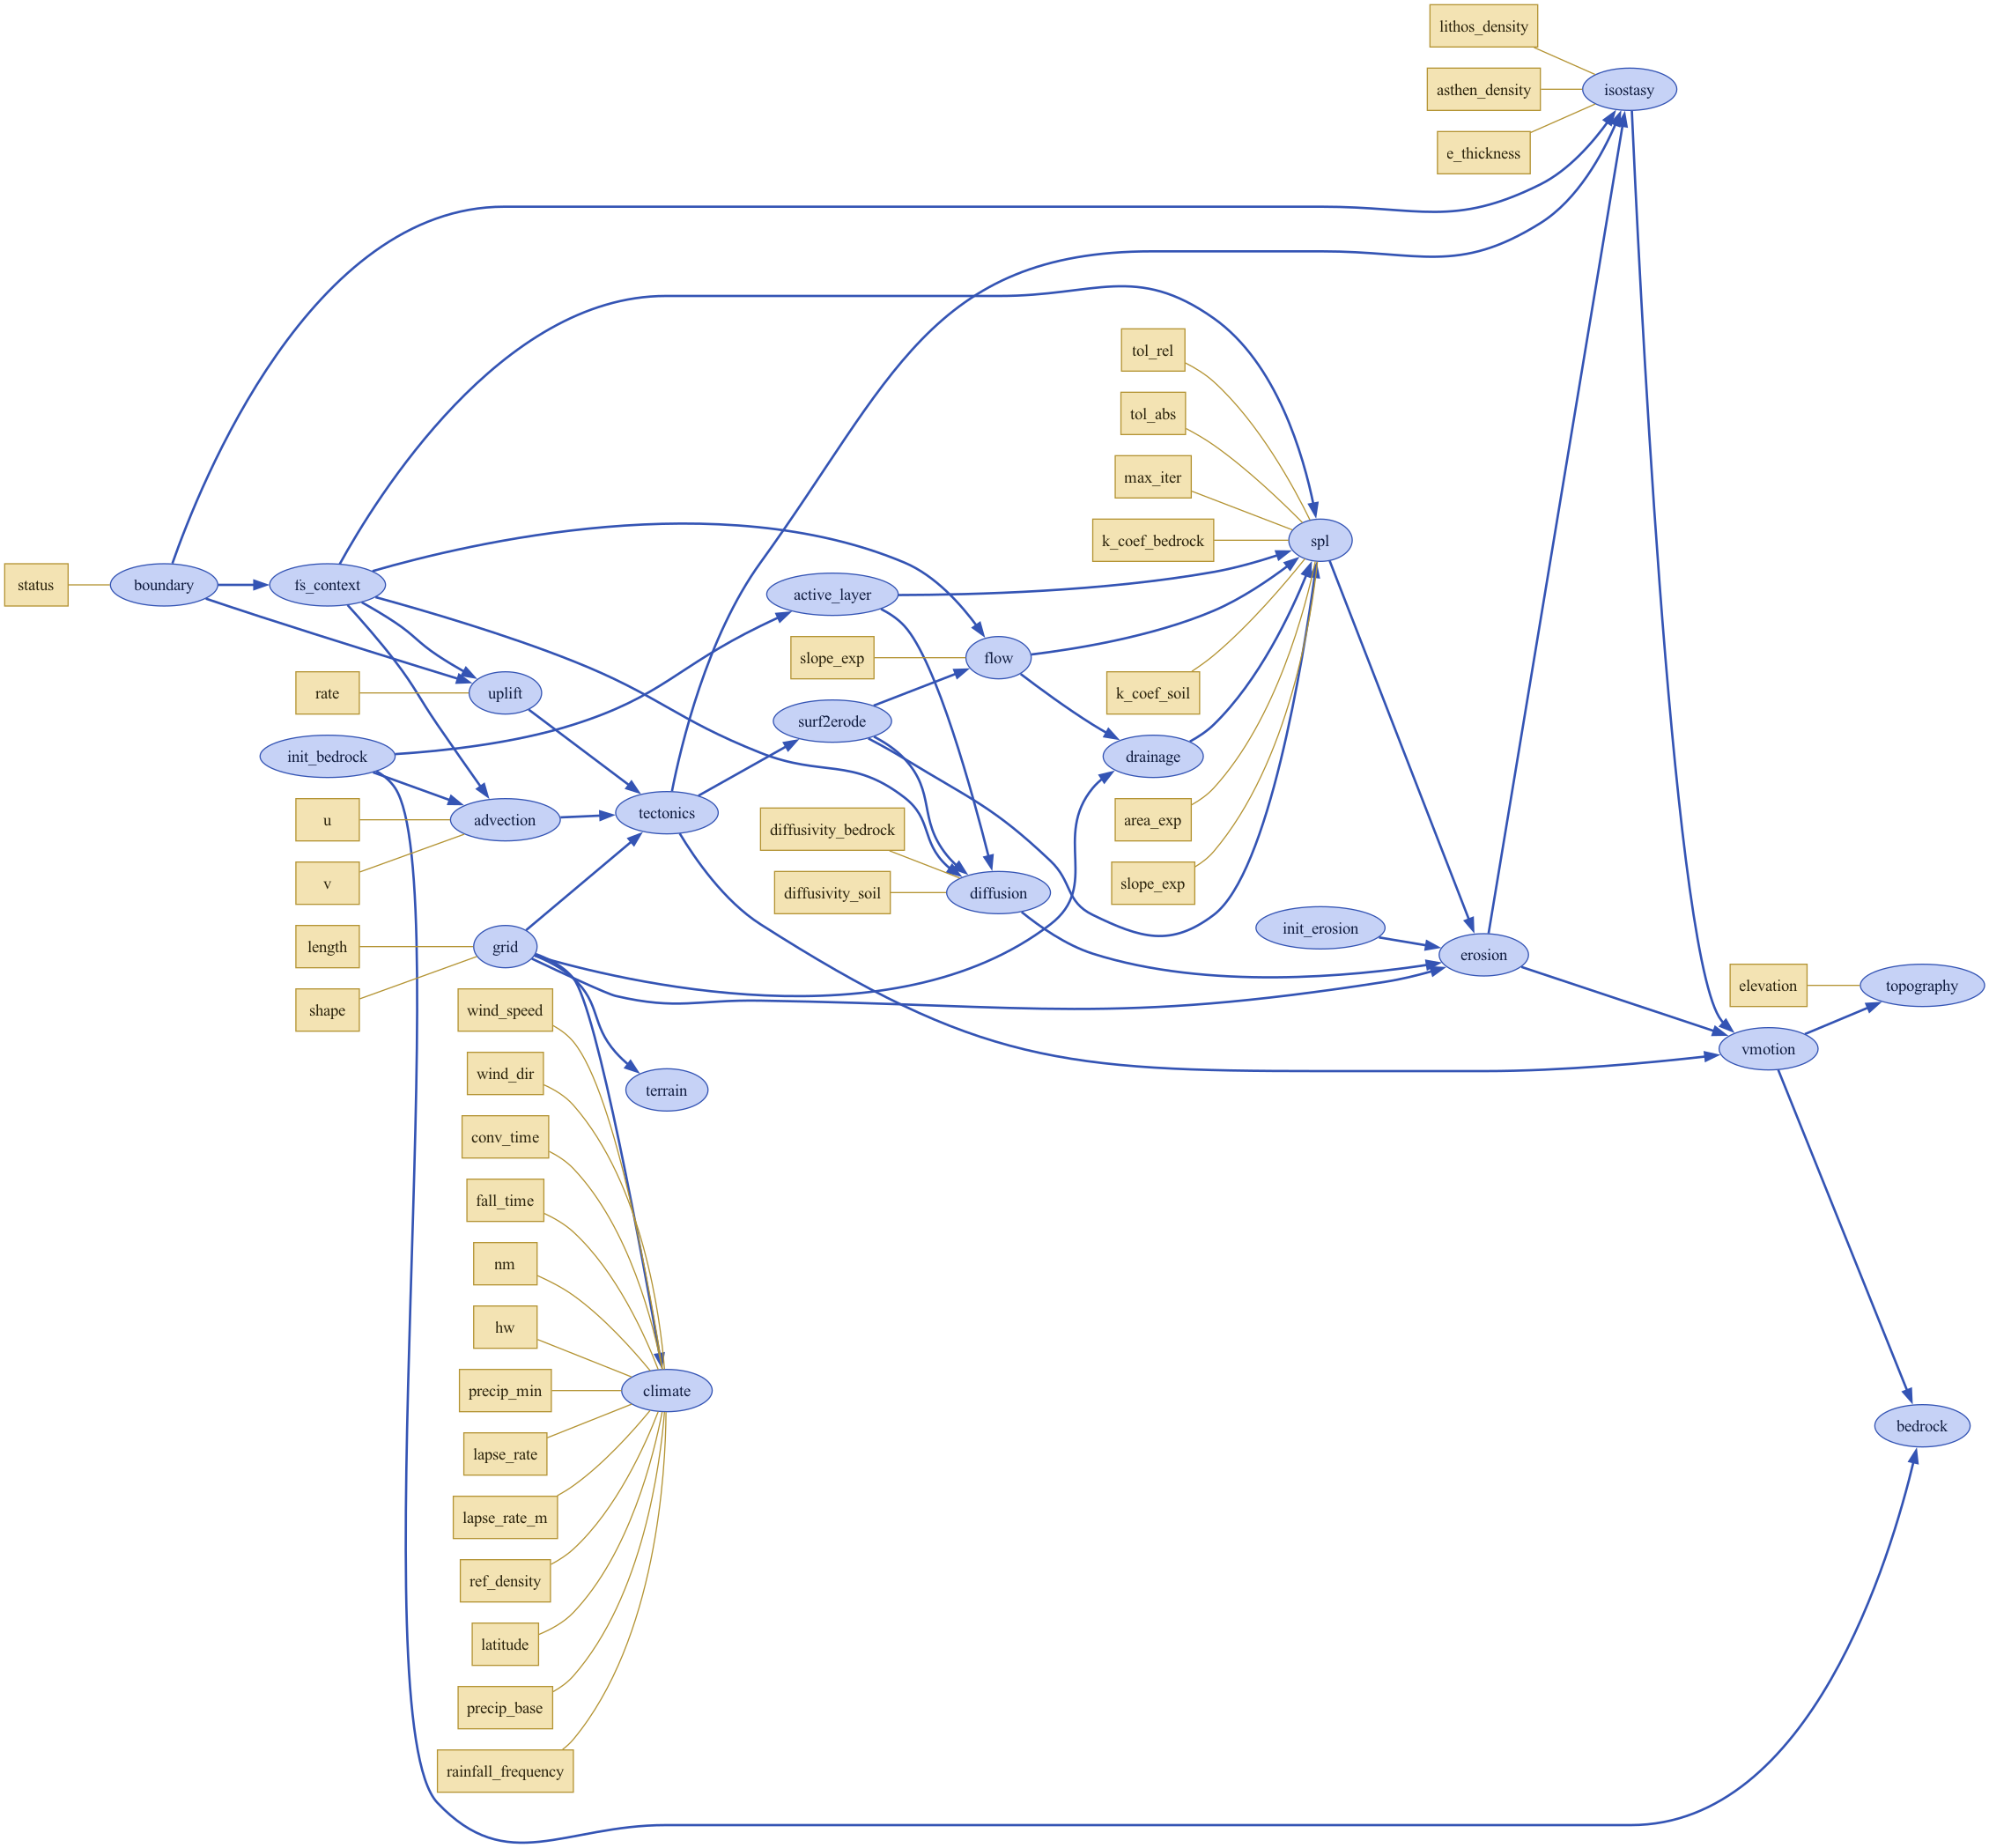

In [25]:
HIM_model.visualize(show_inputs=True)

In [ ]:
import numpy as np
ny, nx = 101, 201                   # 行×列
south_elev, north_elev = 200, 5000  # m

#S-N(101×1)
y = np.linspace(0, 1, ny).reshape(ny, 1)
elev_profile = south_elev + (north_elev - south_elev) * y      # (101,1)
InitialTopography = np.repeat(elev_profile, nx, axis=1)        # (101,201)

ridge_center, ridge_sigma, ridge_height = int(0.55*ny), 6, 1000
InitialTopography += ridge_height * np.exp(
        -((np.arange(ny).reshape(ny,1) - ridge_center)**2) / (2*ridge_sigma**2)
    )

# random
InitialTopography += np.random.default_rng(42).normal(0, 30, (ny, nx))


Uplift_1 = np.zeros((ny, nx))
Uplift_1[:ridge_center-10, :]            = 6e-3   # 前陆
Uplift_1[ridge_center-10:ridge_center+10,:] = 8e-3   # 主脊
Uplift_1[ridge_center+10:, :]            = 3e-3   

Lateral_xAdvection_1 = np.zeros((ny, nx))          
Lateral_yAdvection_1 = np.zeros((ny, nx))
Lateral_yAdvection_1[:ridge_center, :] = 1e-2      

In [ ]:
import numpy as np
import xsimlab as xs

time_clock = np.arange(0, 9.0e6 + 1.0e3, 1.0e3)   # master
out_clock  = np.arange(0, 9.0e6 + 1.0e5, 1.0e5)   # output
in_ds_him = xs.create_setup(
    model=HIM_model,                
    clocks=dict(
        time=np.arange(0, 9.0e6 + 1.0e3, 1.0e3),
        out =np.arange(0, 9.0e6 + 1.0e5, 1.0e5)
    ),
    master_clock="time",
    input_vars={
        "grid__shape"      : [101, 201],          # ny, nx
        #"grid__shape"      : [201, 401],          # ny, nx
        "grid__length"     : [1.0e5, 2.0e5],      # 100 km × 200 km
        "boundary__status" : ["fixed_value", "core", "looped", "looped"],


        "uplift": {
            "rate": Uplift_1
        },
        "advection": {
            "u": 0,                               # x 向 0
            "v": Lateral_yAdvection_1
        },
        "isostasy": {
            "e_thickness"   : 25e3,  # m
            "lithos_density": 2700.,
            "asthen_density": 3300.
        },

    
        # "spl": {
        #     "k_coef_bedrock": 5e-6,
        #     "k_coef_soil"   : 5e-5,
        #     "area_exp"      : 0.45,
        #     "slope_exp"     : 0.7
        # },

         "spl": {
            "k_coef_bedrock": 1e-4,
            "k_coef_soil"   : 2e-4,
            "area_exp"      : 0.45,
            "slope_exp"     : 1.0
        },


        "diffusion": {
            "diffusivity_bedrock": 3e-2,
            "diffusivity_soil"   : 1e-2,
            #"slope_crit"         : 0.7
        },

        "climate": {
            "precip_base"       : 1.8,      # m yr⁻¹ 南坡基准
            #"dPdx"     : -1.5e-2,  # 每 km -1.5 %
            "wind_dir" : 180.,      # 南→北
            "wind_speed" : 4.0,
            "latitude" :28.0
        }
    },

    output_vars={
        "topography": {
            "elevation": "out"
        },
        "erosion": {
            "rate": "out"
        },
        "spl": {
            "chi": "out",
            "flowacc": "out"
        },
        "climate": {
            "precip_rate": "out"
        }
    }
)
ny, nx = 101, 201 
in_ds_him = in_ds_him.assign_coords(
    y=("y", np.arange(ny)),       # 节点索引或真实距离都行
    x=("x", np.arange(nx))
)
in_ds_him["topography__elevation"] = (("y", "x"), InitialTopography)

/opt/anaconda3/envs/mle/lib/python3.10/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)
/opt/anaconda3/envs/mle/lib/python3.10/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'out' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


In [ ]:

with xs.monitoring.ProgressBar():
    out_ds = in_ds_him.xsimlab.run(model=HIM_model)
out_ds.coords["x"].attrs["units"]   = "m"
out_ds.coords["y"].attrs["units"]   = "m"
out_ds.coords["out"].attrs["units"] = "years"

out_ds["topography__elevation"].attrs["units"] = "m"
out_ds["erosion__rate"].attrs["units"]         = "m/yr"
out_ds["climate__precip_rate"].attrs["units"]  = "m/yr"

out_ds["topography__elevation"].to_netcdf("HIM_elevation.nc")
out_ds["erosion__rate"].to_netcdf("HIM_erosion_rate.nc")
out_ds["climate__precip_rate"].to_netcdf("HIM_precip.nc")

print(" 网格变量已按 ParaView 写入当前目录")

             0% | initialize 

/opt/anaconda3/envs/mle/lib/python3.10/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


✅  网格变量已按 ParaView 友好格式写入当前目录


In [29]:
print("初始脊顶:", out_ds.topography__elevation.isel(out=0).max().item(), "m")
print("9 Myr 脊顶:", out_ds.topography__elevation.isel(out=-1).max().item(), "m")

初始脊顶: 5087.684099277752 m
9 Myr 脊顶: 43138.41382541508 m


In [30]:
rate_ds = xr.open_dataset("HIM_erosion_rate.nc")
print("     侵蚀极小值:", rate_ds.erosion__rate.min().item(), "m/yr")
print("平均侵蚀速率:", rate_ds.erosion__rate.mean(("y","x")).isel(out=-1).item(), "m/yr")

     侵蚀极小值: -0.08717046380322625 m/yr
平均侵蚀速率: 0.0018046974839680712 m/yr
